# 📈FOREX Trend Predictions - Classic ML approach
---
This notebook shows how to create a **very simple machine learning model** that attempts to **predict trends in the FOREX market**. Price forecasting is a very advanced technique, so we will only classify trends as either up, down, or undetermined. This will lay the foundation for future algorithms. Here is a brief summary of what will be accomplished:
- Download historical data up until today's date
- Create different features that could be useful for the model
- Train a simple KNN classifier to predict the next trend
- Evaluate the model and save it.

## References:
- [Code Trading](https://www.youtube.com/@CodeTradingCafe) on YouTube

# Imports
Let's install and import what is needed for the notebook.

In [1]:
!pip install yfinance
!pip install pandas_ta

import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from scipy.stats import linregress
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

import joblib

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
clear_output()

# Load online data
Let's download the historical data of the **EUR/USD** market using **yahoo-finance library** until today's date. The data is stored in a dataframe named `df`.

The function `download()` takes arguments `tickers` to specify the currency pair to download, `period` to specify the time period to download (in this case, 3000 days), and `interval` to specify the frequency of the data (in this case, daily).

In [2]:
df = yf.download(tickers='EURUSD=X',
                 period='3000d',
                 interval='1d')
df = df.drop(['Volume', 'Adj Close'], axis=1)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2011-08-31,1.443460,1.446801,1.439802,1.443314
2011-09-01,1.437505,1.437794,1.422961,1.437463
2011-09-02,1.426208,1.428796,1.419305,1.426208
2011-09-05,1.415568,1.417193,1.406588,1.415769
2011-09-06,1.406905,1.423690,1.397526,1.406312


# Create new features
These lines of code add the following new features to the dataframe `df` that are commonly used in technical analysis for trading predictions. Computations are done with the `pandas_ta` library.

- **ATR:** Calculates and adds the Average True Range (ATR) indicator to the dataframe. ATR is a measure of volatility and is commonly used to determine the size of a stop loss or take profit level.

- **RSI:** Calculates and adds the Relative Strength Index (RSI) indicator to the dataframe. RSI is a momentum oscillator that measures the strength of price movements and is commonly used to identify overbought or oversold conditions.

- **Average:** Calculates and adds the mid-price of the currency pair to the dataframe. The mid-price is the average of the bid and ask prices and can be used as a simple indicator of market sentiment.

- **MA40:** Calculates and adds the 40-day Simple Moving Average (SMA) indicator to the dataframe. The SMA is a commonly used trend-following indicator that smooths out price movements and can be used to identify trends.

- **MA80:** Calculates and adds the 80-day SMA indicator to the dataframe.

- **MA160:** Calculates and adds the 160-day SMA indicator to the dataframe.

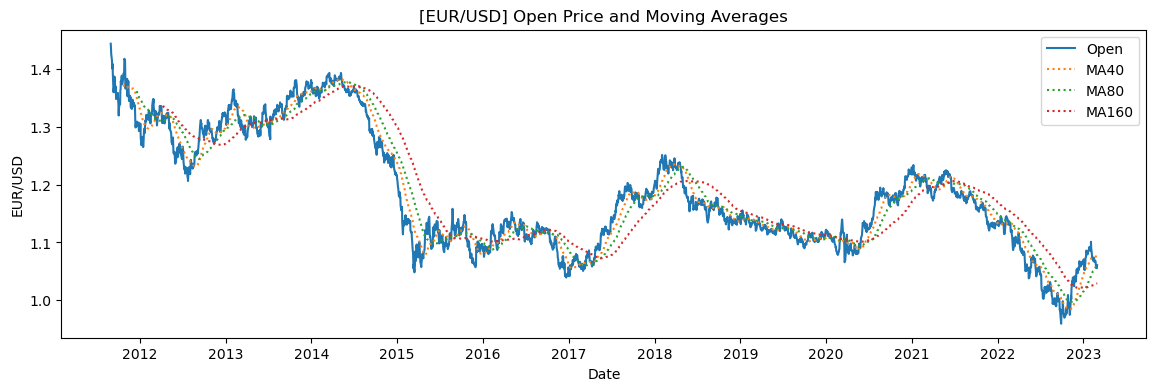

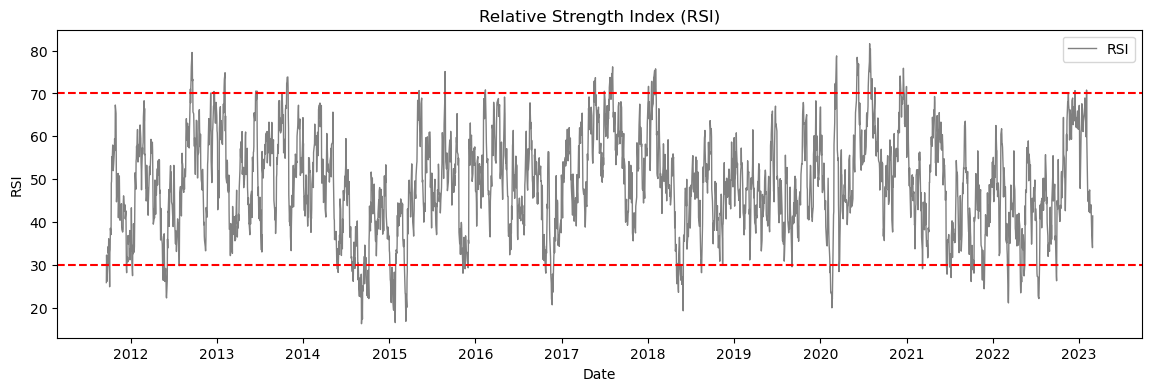

In [3]:
# Get new features
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1)
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

# Plot open price and moving averages
plt.figure(figsize=(14, 4))
plt.plot(df.index, df.Open)
plt.plot(df.index, df.MA40, ls=':')
plt.plot(df.index, df.MA80, ls=':')
plt.plot(df.index, df.MA160, ls=':')
plt.legend(['Open', 'MA40', 'MA80', 'MA160'])
plt.title('[EUR/USD] Open Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('EUR/USD')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

# Plot RSI
plt.figure(figsize=(14, 4))
plt.plot(df.index, df.RSI, lw=1, color='gray')
plt.axhline(70, ls='--', color='red')
plt.axhline(30, ls='--', color='red')
plt.legend(['RSI'])
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

We define now a function `get_slope` that takes an array and returns the slope of a linear regression line fitted to the values in the array. We then use this function to calculate the slopes of the moving averages (MA40, MA80, and MA160), the average price (Average), and the relative strength index (RSI) over a rolling window of 6 periods. Finally, we plot the calculated slopes of the moving averages over time.

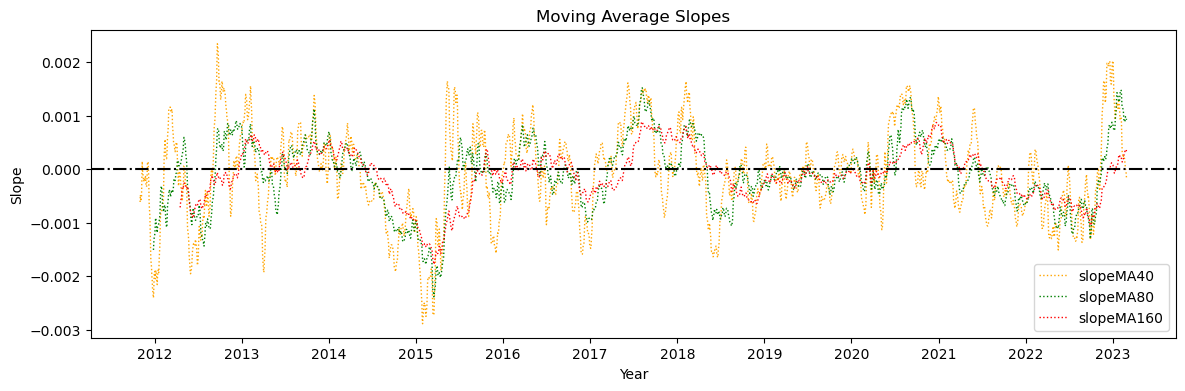

In [4]:
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope = linregress(x, y)[0]
    return slope

# Get slope features
back_rolling_n = 6
df['slopeMA40'] = df['MA40'].rolling(window=back_rolling_n).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=back_rolling_n).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=back_rolling_n).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=back_rolling_n).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=back_rolling_n).apply(get_slope, raw=True)

# Plot the moving average slopes
plt.figure(figsize=(14, 4))
plt.plot(df.index, df.slopeMA40, lw=1, ls=':', color='orange')
plt.plot(df.index, df.slopeMA80, lw=1, ls=':', color='green')
plt.plot(df.index, df.slopeMA160, lw=1, ls=':', color='red')
plt.axhline(0, ls='-.', color='black')
plt.legend(['slopeMA40', 'slopeMA80', 'slopeMA160'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.title('Moving Average Slopes')
plt.xlabel('Year')
plt.ylabel('Slope')
plt.show()

# Define target
We must now define the target variable for our machine learning model. As predicting actual prices can be very challenging, we will instead classify the trend of the market into three categories. To achieve this, we are using the `get_target` function which takes two arguments: the number of bars to look ahead (barsupfront) and the DataFrame containing our financial data (df).

The function calculates the highest and lowest values for each bar in the specified range and determines the market's status:
- There is no clear trend: **class 0**
- The trend goes down: **class 1**
- The trend goes up: **class 2**

Finally, the function assigns the trend category to each data point in the DataFrame as a `target` column. This column will be used as the target variable in our machine learning model to predict the trend of the market.

In [5]:
pipdiff = 500*1e-5 # for take profit (TP)
SLTPRatio = 2

def get_target(barsupfront, df):
    length = len(df)
    high = list(df['High'])
    low = list(df['Low'])
    close = list(df['Close'])
    open = list(df['Open'])
    trendcat = [None] * length
    
    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(0, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
            
            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio))):
                trendcat[line] = 1 # Downtrend
                break
            elif ((valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2 # Uptrend
                break
            else:
                trendcat[line] = 0 # No clear trend
                
    return trendcat

df['target'] = get_target(16, df)

# Check the feature distributions
We can plot the distribution of the different features to quickly check if there is any abnormalities in the data. It seems to be ok at the moment.

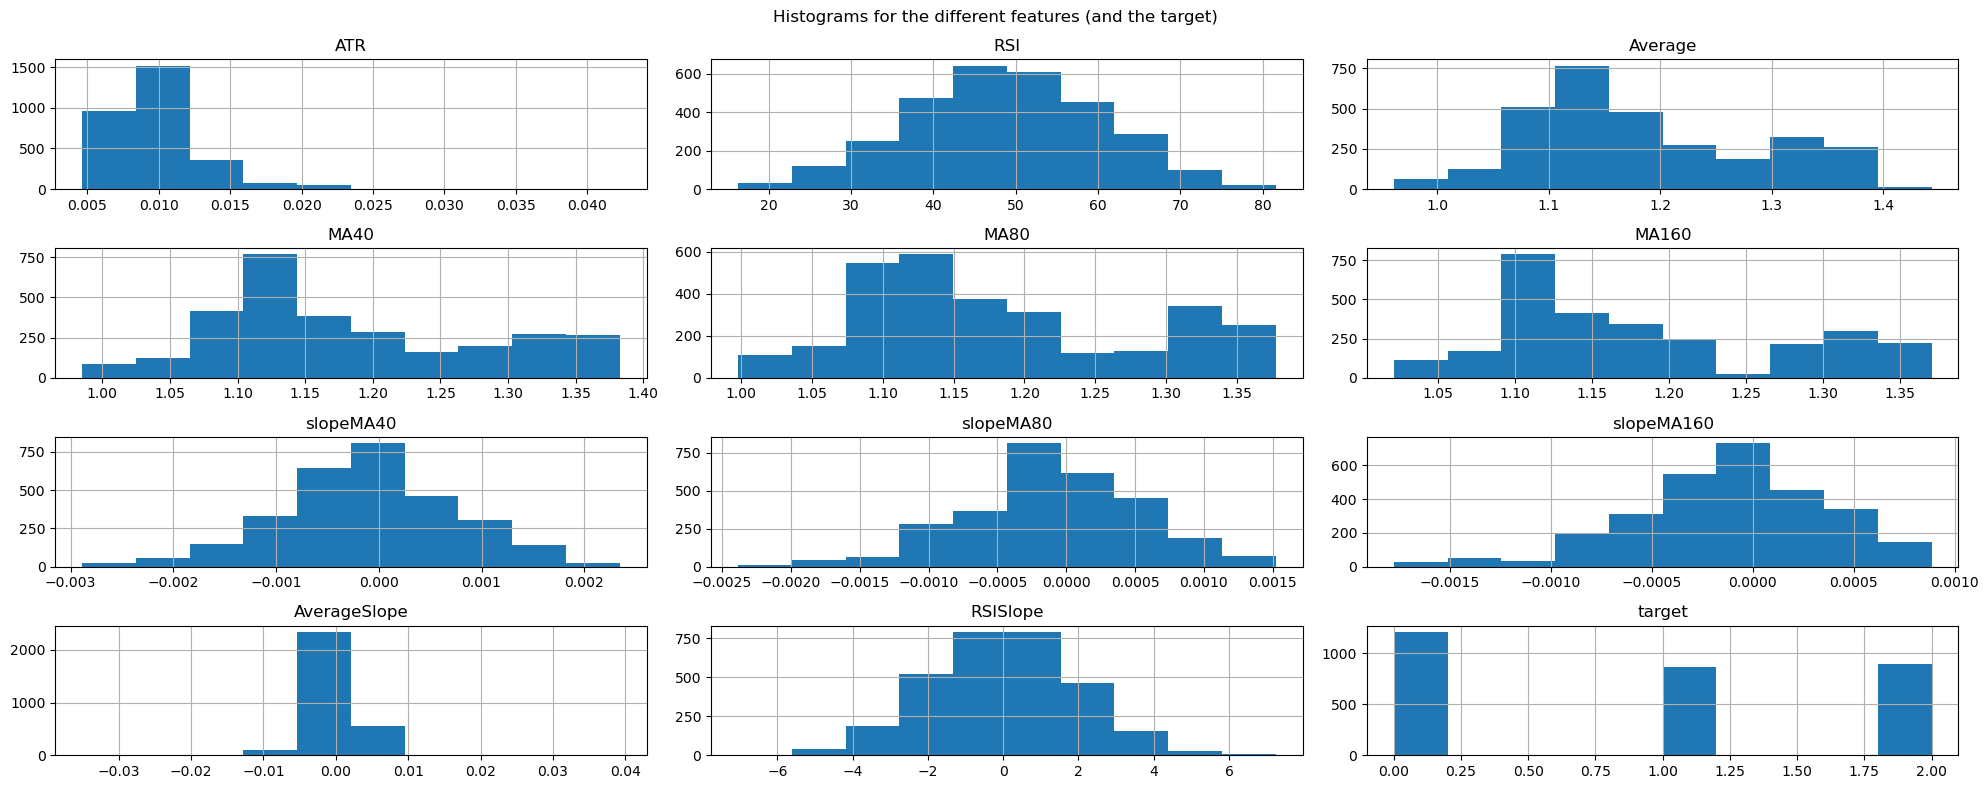

In [6]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()
df_model = df[['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160',
              'slopeMA40', 'slopeMA80', 'slopeMA160',
              'AverageSlope', 'RSISlope', 'target']] 
df_model.hist(ax=ax)
plt.suptitle("Histograms for the different features (and the target)")
plt.tight_layout()
plt.show()

Let's also check the distribution of RSI within the different target classes. As we can see, the three distributions seem to follow the same pattern, indicating that relying solely on this feature is unlikely to yield accurate predictions. To uncover correlations, we will need to combine it with other features.

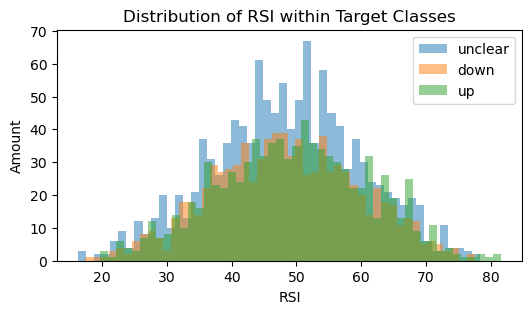

In [7]:
plt.figure(figsize=(6, 3))
df_up = df.RSI[df.target == 2]
df_down = df.RSI[df.target == 1]
df_unclear = df.RSI[df.target == 0]
plt.hist(df_unclear, bins=50, alpha=0.5, label='unclear')
plt.hist(df_down, bins=50, alpha=0.5, label='down')
plt.hist(df_up, bins=50, alpha=0.5, label='up')
plt.title('Distribution of RSI within Target Classes')
plt.xlabel('RSI')
plt.ylabel('Amount')
plt.legend()
plt.show()

# Splitting features and target
It is now time to prepare the data for the **KNN classifier**. We will separate the dataframe into X and y, which will respectively contain the features and the targets. It is important to note that we will not be selecting the absolute values of the close, open, high, and low prices. This is because the model would not be able to make accurate predictions based solely on these simple values. Another way to think about it is that if given a random value of the exchange rate of the currency, you would not be able to predict the trend. This is because the trend depends mostly on the past few days together and not on a single value at a given moment. Then, we use the features we previously created.

In [8]:
df_model = df_model.dropna()
features = ['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160',
            'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[features]
y = df_model['target']
X.head()

,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
Date,,,,,,,,,,,
2012-04-17,0.013604,46.695658,1.312794,1.322138,1.311491,1.332832,-0.000071,0.000080,-0.000714,-0.000225,0.728983
2012-04-18,0.013335,47.279913,1.310121,1.321868,1.311570,1.332289,-0.000135,0.000089,-0.000654,-0.000547,0.850598
2012-04-19,0.013095,46.296746,1.311430,1.321528,1.311811,1.331686,-0.000236,0.000104,-0.000614,-0.000488,0.153696
2012-04-20,0.012964,48.230487,1.317834,1.320959,1.312048,1.331212,-0.000334,0.000133,-0.000577,0.001167,0.175852
2012-04-23,0.012827,52.438013,1.315896,1.320303,1.312354,1.330964,-0.000401,0.000192,-0.000506,0.002153,1.621000


# Splitting train and validation sets
Finally, in order to evaluate the performance of the model, we should train it on a fraction of the data and keep the remaining part for validation. Traditionally, we would take the whole dataset, shuffle it, and randomly select samples for training and validation. However, in our context, the features we created are very similar from one day to another. This is not the case for the targets, which can change from an uptrend to a downtrend for example.

Therefore, we will keep the first 80% of the data for training and evaluate the model on the 20% most recent records. This way, the model will learn that even if two records of features are very similar, their targets may not necessarily be the same. This also helps us understand why forecasting in trading is a very challenging task.

In [9]:
split_index = int(0.8 * len(df_model))
X_train, X_valid = X[:split_index], X[split_index:]
y_train, y_valid = y[:split_index], y[split_index:]

# KNN Classifier
Let's try with a simple KNN classifier baseline. I have optimized the parameters upstream with a search grid.

In [10]:
# Fitting and predictions
model = KNeighborsClassifier(n_neighbors=225,
                             weights='uniform',
                             algorithm='ball_tree',
                             leaf_size=30,
                             p=1,
                             metric='minkowski',
                             metric_params=None,
                             n_jobs=1)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
gambler_pred = np.random.choice([0, 1, 2], len(y_pred_valid))

# Evaluating
train_accuracy = accuracy_score(y_train, y_pred_train)
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
gambler_accuracy = accuracy_score(y_valid, gambler_pred)
base_accuracy = max(df_model.target.value_counts().sort_index() / len(df_model))
print(f"Train accuracy:   {train_accuracy * 100 :.2f}%")
print(f"Valid accuracy:   {valid_accuracy * 100 :.2f}%")
print(f"Gambler accuracy: {gambler_accuracy * 100 :.2f}%")
print("\nRepartition of the classes:")
print(df_model.target.value_counts().sort_index() / len(df_model))
print(f"\n=== Accuracy advantage: {(valid_accuracy - base_accuracy) * 100 :.2f}% ===")

Train accuracy:   39.69%
Valid accuracy:   42.45%
Gambler accuracy: 32.33%

Repartition of the classes:
0.0    0.405617
1.0    0.293281
2.0    0.301102
Name: target, dtype: float64

=== Accuracy advantage: 1.89% ===


We can say a few things about this:

- There is a slight class imbalance, with about 40% of the data belonging to class 0, while 30% belong to class 1 and 2 each.
- If we were to randomly predict the classes, we would expect a score of roughly 1/3 without class imbalance.
- Our test accuracy is about 42%, which is better than that of a gambler's predictor. However, by always predicting the most frequent class, we would get an accuracy of 40%. This is why we should look at the percentage gain of the KNN.
- **This model is not very good, but has still an advantage of 1.89%.**

# Save the model
Let's save the model to be able to reuse it somewhere else.

In [11]:
filename = 'model.sav'
joblib.dump(model, filename)
loaded_model = joblib.load(filename)